In [5]:
# Imports
import cv2
from flax import nnx
import jax
import jax.numpy as jnp
import optax
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from functools import partial
from celebrity_dataset import CelebrityDataset, TRAIN_LIST, VAL_LIST

In [6]:
# Transforms
class ResizeTransform:
    def __init__(self, size: int):
        self.size = size
    def __call__(self, x):
        return cv2.resize(x, (self.size, self.size))
# class NormalizeTransform:
#     def __init__(self, mean: float, std: float):
#         self.mean = mean
#         self.std = std
#     def __call__(self, x):
#         return (x - self.mean) / self.std

# Collate function
def collate_fn(x):
    return jnp.stack(x)

train_ds = CelebrityDataset(TRAIN_LIST, transform=ResizeTransform(224))
train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True,
    num_workers=0, # mp not working well in notebook
    collate_fn=collate_fn)

In [7]:

class ConvBlock(nnx.Module):
    def __init__(self, in_ch, out_ch, *, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(in_ch, out_ch, kernel_size=(3, 3), padding='SAME', rngs=rngs)
        self.bn1 = nnx.BatchNorm(out_ch, rngs=rngs)
        self.conv2 = nnx.Conv(out_ch, out_ch, kernel_size=(3, 3), padding='SAME', rngs=rngs)
        self.bn2 = nnx.BatchNorm(out_ch, rngs=rngs)

    def __call__(self, x, *, training: bool):
        x = nnx.relu(self.bn1(self.conv1(x), use_running_average=not training))
        x = nnx.relu(self.bn2(self.conv2(x), use_running_average=not training))
        return x

class UNet(nnx.Module):
    def __init__(self, in_ch, out_ch, *, rngs: nnx.Rngs):
        # Downsampling path
        self.down1 = ConvBlock(in_ch, 64, rngs=rngs)
        self.down2 = ConvBlock(64, 128, rngs=rngs)
        self.down3 = ConvBlock(128, 256, rngs=rngs)
        self.down4 = ConvBlock(256, 512, rngs=rngs)

        self.mid = ConvBlock(512, 1024, rngs=rngs)

        # Upsampling path (ConvTranspose + ConvBlock)
        self.upconv4 = nnx.ConvTranspose(1024, 512, kernel_size=(2, 2), strides=(2, 2), rngs=rngs)
        self.up4 = ConvBlock(1024, 512, rngs=rngs)

        self.upconv3 = nnx.ConvTranspose(512, 256, kernel_size=(2, 2), strides=(2, 2), rngs=rngs)
        self.up3 = ConvBlock(512, 256, rngs=rngs)

        self.upconv2 = nnx.ConvTranspose(256, 128, kernel_size=(2, 2), strides=(2, 2), rngs=rngs)
        self.up2 = ConvBlock(256, 128, rngs=rngs)

        self.upconv1 = nnx.ConvTranspose(128, 64, kernel_size=(2, 2), strides=(2, 2), rngs=rngs)
        self.up1 = ConvBlock(128, 64, rngs=rngs)

        self.out_conv = nnx.Conv(64, out_ch, kernel_size=(1, 1), rngs=rngs)
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))

    def __call__(self, x, *, training: bool):
        d1 = self.down1(x, training=training)
        d2 = self.down2(self.pool(d1), training=training)
        d3 = self.down3(self.pool(d2), training=training)
        d4 = self.down4(self.pool(d3), training=training)

        mid = self.mid(self.pool(d4), training=training)

        u4 = self.up4(jnp.concatenate([self.upconv4(mid), d4], axis=-1), training=training)
        u3 = self.up3(jnp.concatenate([self.upconv3(u4), d3], axis=-1), training=training)
        u2 = self.up2(jnp.concatenate([self.upconv2(u3), d2], axis=-1), training=training)
        u1 = self.up1(jnp.concatenate([self.upconv1(u2), d1], axis=-1), training=training)

        return nnx.sigmoid(self.out_conv(u1))
    

model = UNet(3, 3, rngs=nnx.Rngs(42))
nnx.display(model)

In [8]:
lr = 1e-4
momentum = 0.9

optimizer = nnx.Optimizer(model, tx=optax.adamw(lr, momentum))
metrics = nnx.MultiMetric(
    loss = nnx.metrics.Average("loss")
)
nnx.display(optimizer)

In [9]:
def loss_function(model: nnx.Module, batch):
    logits = model(batch, training=True)
    loss = optax.l2_loss(logits, batch).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_function, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits)
    optimizer.update(grads=grads)



11it [01:18,  7.12s/it]


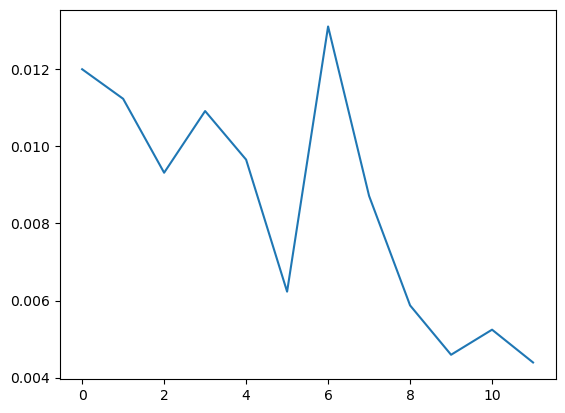

In [13]:
from tqdm import tqdm
metrics_ = {
    "loss": [],
}

for step, batch in tqdm(enumerate(train_loader)):
    train_step(model, optimizer, metrics, batch)

    if step % 1 == 0:
        for m, v in metrics.compute().items():
            metrics_[m].append(v)
        metrics.reset()
    
    if step > 10:
        break

plt.plot(metrics_["loss"])


0.4709837 0.7608316


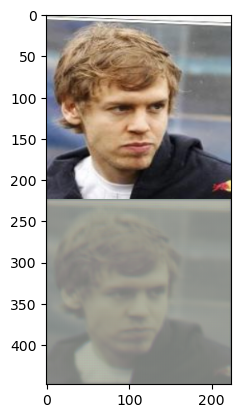

In [14]:
sample_input = next(iter(train_loader))
sample_output = model(sample_input, training=False)

both = jnp.concatenate([sample_input, sample_output], axis=1)[0]
plt.imshow(both)

print(sample_output.min(), sample_output.max())